In [1]:
import pandas as pd 
import numpy as np
import json
import time

In [2]:
#opening the json file and converting into a pandas dataframe
transac = []
f = open('transaction-data-adhoc-analysis.json')
data = json.load(f)

#create a dataframe using the same logic done for the ISS assesssment
for i in range(0,len(data)):
        transac.append((data[i]['address'],data[i]['birthdate'],data[i]['mail'],data[i]['name'],data[i]['sex'],data[i]['username'],data[i]['transaction_items'],data[i]['transaction_value'],data[i]['transaction_date']))
transac_data = pd.DataFrame(transac, columns = ['Address','Birthdate','Mail','Name','Sex','Username','Transaction_Items','Transaction_Value','Transaction_Date'])

#multiple item inputs in one row in Transaction_Items will be separated into different rows
#code from thewwebdev link: https://thewebdev.info/2022/03/26/how-to-split-text-in-a-column-into-multiple-rows-with-python-pandas/
transac_data['Transaction_Items'] = transac_data['Transaction_Items'].str.split(';')
transac_data = transac_data.explode('Transaction_Items').reset_index(drop=True)
cols = list(transac_data.columns)
cols.append(cols.pop(cols.index('Username')))
transac_data = transac_data[cols]

#creating a new column for the quantity
#code from stackoverflow link: https://stackoverflow.com/questions/14745022/how-to-split-a-dataframe-string-column-into-two-columns
transac_data[['Brand_Name', 'Product_Name', 'Quantity']] = transac_data['Transaction_Items'].str.split(',', expand=True)

In [3]:
#removing the parentheses and 'x' in the quantity column and making the number an integer
#code from stackoverflow link:https://stackoverflow.com/questions/13682044/remove-unwanted-parts-from-strings-in-a-column
transac_data['Quantity'] = transac_data['Quantity'].str.replace(r'\D', '').astype(int)

/var/folders/yd/cmt_vsbj2wj5db7l6nvzxs1m0000gn/T/ipykernel_36741/3617963641.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  transac_data['Quantity'] = transac_data['Quantity'].str.replace(r'\D', '').astype(int)


In [4]:
#check datatype of quantity column
print(transac_data['Quantity'].dtype)

int64


In [5]:
#getting an array of unique product names
# code from sparkbyexamples link: https://sparkbyexamples.com/pandas/pandas-find-unique-values-from-columns/
products = transac_data['Product_Name'].unique()
products

array(['Beef Chicharon', 'Nutrional Milk', 'Orange Beans',
       'Gummy Vitamins', 'Yummy Vegetables', 'Gummy Worms',
       'Kimchi and Seaweed'], dtype=object)

In [6]:
#cannot find a way to insert (transac_data['Product_Name'] == products[i]) within a for loop to get unique products together with its minimum value to get price so it will be manually done
#getting the price
#beefchicharon price
bc = transac_data.loc[(transac_data['Quantity'] == 1) & (transac_data['Product_Name'] == products[0])]
price_bc= bc['Transaction_Value'].min()

#nutritionalmilk price
nm = transac_data.loc[(transac_data['Quantity'] == 1) & (transac_data['Product_Name'] == products[1])]
price_nm= nm['Transaction_Value'].min()

#orangebeans price
ob = transac_data.loc[(transac_data['Quantity'] == 1) & (transac_data['Product_Name'] == products[2])]
price_ob= ob['Transaction_Value'].min()

#gummyvitamins price
gv = transac_data.loc[(transac_data['Quantity'] == 1) & (transac_data['Product_Name'] == products[3])]
price_gv= gv['Transaction_Value'].min()

#yummy vegetables price
yv = transac_data.loc[(transac_data['Quantity'] == 1) & (transac_data['Product_Name'] == products[4])]
price_yv= yv['Transaction_Value'].min()

#gummyworms price
gw = transac_data.loc[(transac_data['Quantity'] == 1) & (transac_data['Product_Name'] == products[5])]
price_gw= gw['Transaction_Value'].min()

#kimchiseaweed price
ks = transac_data.loc[(transac_data['Quantity'] == 1) & (transac_data['Product_Name'] == products[6])]
price_ks= ks['Transaction_Value'].min()

In [7]:
#getting corresponding price
price = []
price.append((price_bc,price_nm,price_ob,price_gv,price_yv,price_gw,price_ks))
print(price)

[(1299, 1990, 199, 1500, 500, 150, 799)]


In [8]:
#create new columnn 
#code from projectpro link:https://www.projectpro.io/recipes/insert-new-column-based-on-condition-in-python
price_value = []
for row in transac_data['Product_Name']:
    if row == products[0]: price_value.append('1299')
    elif row == products[1]: price_value.append('1990')
    elif row == products[2]: price_value.append('199')
    elif row == products[3]: price_value.append('1500')
    elif row == products[4]: price_value.append('500')
    elif row == products[5]: price_value.append('150')
    elif row == products[6]: price_value.append('799')

In [9]:
transac_data['Product_Value'] = price_value
#convert product value to int
transac_data['Product_Value'] = transac_data['Product_Value'].astype(str).astype(int)
transac_data['Product_Value'] = transac_data['Product_Value'] * transac_data['Quantity']

del transac_data['Transaction_Value']

In [10]:
#convert the transaction date into datetime dtype
#code from stackoverflow link: https://stackoverflow.com/questions/26763344/convert-pandas-column-to-datetime
transac_data['Transaction_Date'] = pd.to_datetime(transac_data['Transaction_Date'])

#extract month and year
#code from datascientyst link: https://datascientyst.com/extract-month-and-year-datetime-column-in-pandas/
transac_data['Transaction_Date'] = transac_data['Transaction_Date'].dt.to_period('M')

In [11]:
#using the groupby function to extract quantity and product value for transaction date
#code from pandas pydata org link: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html

#Breakdown of the count of each item sold per month and  total sale value per item per month
item_data = transac_data.groupby(['Transaction_Date','Product_Name']).sum()
item_data

Quantity  Product_Value
Transaction_Date Product_Name                               
2022-01          Beef Chicharon          9665       12554835
                 Gummy Vitamins          9681       14521500
                 Gummy Worms             9559        1433850
                 Kimchi and Seaweed      9676        7731124
                 Nutrional Milk          9727       19356730
                 Orange Beans            9774        1945026
                 Yummy Vegetables        9959        4979500
2022-02          Beef Chicharon         10001       12991299
                 Gummy Vitamins          9980       14970000
                 Gummy Worms             9996        1499400
                 Kimchi and Seaweed      9949        7949251
                 Nutrional Milk          9691       19285090
                 Orange Beans           10037        1997363
                 Yummy Vegetables       10256        5128000
2022-03          Beef Chicharon          9816       12750984
                 Gummy Vitamins         10145       15217500
                 Gummy Worms             9986        1497900
                 Kimchi and Seaweed      9967        7963633
                 Nutrional Milk          9876       19653240
                 Orange Beans            9611        1912589
                 Yummy Vegetables        9896        4948000
2022-04          Beef Chicharon          9890       12847110
                 Gummy Vitamins          9842       14763000
                 Gummy Worms            10043        1506450
                 Kimchi and Seaweed      9921        7926879
                 Nutrional Milk          9786       19474140
                 Orange Beans            9914        1972886
                 Yummy Vegetables        9861        4930500
2022-05          Beef Chicharon         10028       13026372
                 Gummy Vitamins          9948       14922000
                 Gummy Worms             9801        1470150
                 Kimchi and Seaweed      9773        7808627
                 Nutrional Milk          9881       19663190
                 Orange Beans            9964        1982836
                 Yummy Vegetables        9735        4867500
2022-06          Beef Chicharon          9902       12862698
                 Gummy Vitamins          9980       14970000
                 Gummy Worms             9934        1490100
                 Kimchi and Seaweed     10104        8073096
                 Nutrional Milk          9767       19436330
                 Orange Beans           10106        2011094
                 Yummy Vegetables        9722        4861000

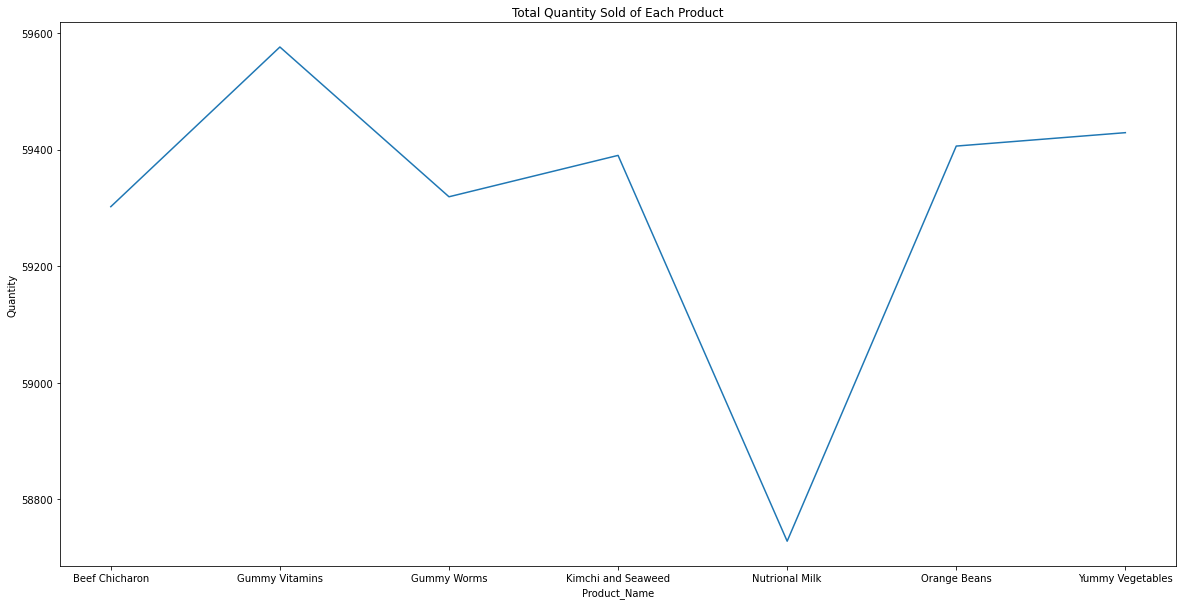

In [12]:
import matplotlib.pyplot as plt 

#Show the graph of the quantity Total Quantity Sold of Each Product
#code for creating plot from a dataframe from pandaspydata link:https://pandas.pydata.org/docs/getting_started/intro_tutorials/04_plotting.html
product_data = transac_data.groupby(['Product_Name']).sum()
plt.figure(figsize=(20,10))
product_data['Quantity'].plot()
plt.xlabel('Product_Name')
plt.ylabel('Quantity')
plt.title('Total Quantity Sold of Each Product')
plt.show()

In [37]:
import datetime as dt
import seaborn as sns

#cohort indexing 
#code from towardsdatascience link:https://towardsdatascience.com/calculate-your-monthly-recurring-customer-by-cohort-analysis-3d39473482b7
transac_data['Purchase_Month'] = transac_data['Transaction_Date']
grouping = transac_data.groupby(['Purchase_Month', 'CohortIndex'])
grouping = transac_data.groupby('Username')['Purchase_Month']
transac_data['Purchase_Month'] = grouping.transform('min')
Month_Diff = transac_data['Transaction_Date'].astype('int') - transac_data['Purchase_Month'].astype('int')
transac_data['CohortIndex'] = Month_Diff +1
transac_data

,Address,Birthdate,Mail,Name,Sex,Transaction_Items,Transaction_Date,Username,Brand_Name,Product_Name,Quantity,Product_Value,Purchase_Month,CohortIndex
0,USNS Wagner\nFPO AE 00917,1926/03/11,watsonbrenda@gmail.com,Jennifer Campbell,F,"Exotic Extras,Beef Chicharon,(x4)",2022-01,veronicawells,Exotic Extras,Beef Chicharon,4,5196,2022-01,1
1,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,"Exotic Extras,Beef Chicharon,(x3)",2022-01,cgilbert,Exotic Extras,Beef Chicharon,3,3897,2022-01,1
2,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,"HealthyKid 3+,Nutrional Milk,(x4)",2022-01,cgilbert,HealthyKid 3+,Nutrional Milk,4,7960,2022-01,1
3,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,"Candy City,Orange Beans,(x1)",2022-01,cgilbert,Candy City,Orange Beans,1,199,2022-01,1
4,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,"HealthyKid 3+,Gummy Vitamins,(x3)",2022-01,cgilbert,HealthyKid 3+,Gummy Vitamins,3,4500,2022-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166114,428 Kristopher Curve Apt. 206\nMcculloughville...,1913/11/04,melvinschmidt@hotmail.com,Donald Andersen,M,"HealthyKid 3+,Nutrional Milk,(x2)",2022-06,llowe,HealthyKid 3+,Nutrional Milk,2,3980,2022-01,6
166115,428 Kristopher Curve Apt. 206\nMcculloughville...,1913/11/04,melvinschmidt@hotmail.com,Donald Andersen,M,"Candy City,Gummy Worms,(x2)",2022-06,llowe,Candy City,Gummy Worms,2,300,2022-01,6
166116,"PSC 1089, Box 3720\nAPO AE 08973",2012/04/30,xjones@hotmail.com,Stephanie Russell,F,"HealthyKid 3+,Nutrional Milk,(x1)",2022-06,cmcdowell,HealthyKid 3+,Nutrional Milk,1,1990,2022-01,6
166117,"PSC 1089, Box 3720\nAPO AE 08973",2012/04/30,xjones@hotmail.com,Stephanie Russell,F,"Candy City,Gummy Worms,(x3)",2022-06,cmcdowell,Candy City,Gummy Worms,3,450,2022-01,6


In [28]:
grouping = transac_data.groupby(['Purchase_Month', 'CohortIndex'])
cohort_data = grouping['Username'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()

cohort_counts = cohort_data.pivot(index="Purchase_Month",
                                  columns="CohortIndex",
                                  values="Username")
retention = cohort_counts
retention = retention.fillna(0)

In [29]:
#convert pivot table to dataframe
#code from statology link: https://www.statology.org/pandas-pivot-table-to-dataframe/

loyalty_program = retention.reset_index()

In [30]:
loyalty_program

CohortIndex,Purchase_Month,1,2,3,4,5,6
0,2022-01,6583.0,5167.0,5220.0,5152.0,5143.0,5189.0
1,2022-02,1463.0,1098.0,1065.0,1092.0,1126.0,0.0
2,2022-03,340.0,257.0,254.0,257.0,0.0,0.0
3,2022-04,94.0,76.0,74.0,0.0,0.0,0.0
4,2022-05,22.0,16.0,0.0,0.0,0.0,0.0
5,2022-06,3.0,0.0,0.0,0.0,0.0,0.0


In [31]:
jan = '0'
feb = loyalty_program[2][0]
march = loyalty_program[3][0] + loyalty_program[2][1]
april = loyalty_program[4][0] + loyalty_program [3][1] + loyalty_program[2][2]
may = loyalty_program[5][0] + loyalty_program[4][1] + loyalty_program[3][2] + loyalty_program[2][3]
june = loyalty_program[6][0] + loyalty_program[5][1] + loyalty_program[4][2] + loyalty_program[3][3] + loyalty_program[2][4]

In [32]:
Repeaters = []
Repeaters.append((jan,feb,march,april,may,june))

In [33]:
dates = []
for i in range(0, len(loyalty_program['Purchase_Month'])):
    dates.append(str(loyalty_program['Purchase_Month'][i]))
    i+=1

In [34]:
loy = pd.DataFrame(Repeaters, columns = [dates])
loy.index = ['Repeaters']
loy

,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06
Repeaters,0,5167.0,6318.0,6474.0,6565.0,6662.0


In [35]:
#see how many months the user had atleast 1 purchase
#code from stackoverflow link: https://stackoverflow.com/questions/70156300/pandas-groupby-aggregate-to-find-number-of-days-customer-made-at-least-1-transac
out = transac_data.groupby('Username').agg(Number_of_Months_Active = ('Transaction_Date','nunique')).reset_index()

In [36]:
out

,Username,Number_of_Months_Active
0,aadams,5
1,aaguilar,3
2,aalvarez,4
3,aaron02,5
4,aaron15,4
...,...,...
8500,zwatson,4
8501,zweber,5
8502,zwelch,6
8503,zwhite,5
